In [9]:
from quadmodel.inference.forward_model import forward_model
import os
import numpy as np
import matplotlib.pyplot as plt

### Forward modeling image flux ratios with quadmodel

In the following cell, we define the parameters we want to sample in the forward model, and set the lens data class

In [10]:
output_path = os.getcwd() + '/example_inference_output/'
job_index = 1
n_keep = 2
summary_statistic_tolerance = 1e4
lens_data = 'B1422'
from quadmodel.data.b1422 import B1422
lens_data = B1422()
print(lens_data.m)
print(lens_data.macromodel_type)
realization_priors = {}
realization_priors['PRESET_MODEL'] = 'WDM'
realization_priors['sigma_sub'] = ['UNIFORM', 0.0, 0.1]
realization_priors['LOS_normalization'] = ['FIXED', 1.]
realization_priors['log_mc'] = ['UNIFORM', 4.8, 10.0]
realization_priors['log_m_host'] = ['FIXED', 13.3]

macromodel_priors = {}
macromodel_priors['m4_amplitude_prior'] = [np.random.normal, 0.0, 0.01]
macromodel_priors['gamma_macro_prior'] = [np.random.uniform, 1.8, 2.3]
# FOR A CUSTOM SHEAR PRIOR:
# macromodel_priors['shear_strength_prior'] = [np.random.uniform, 0.05, 0.25]

# the present lenses also have built-in shear priors determined based on what values get accepted after running ABC;
# using a brooader prior, you will waste some time exploring parameter space that will get rejected
shear_min, shear_max = lens_data.kwargs_macromodel['shear_amplitude_min'], lens_data.kwargs_macromodel['shear_amplitude_max']
print(shear_min, shear_max)
macromodel_priors['shear_strength_prior'] = [np.random.uniform, shear_min, shear_max]


[0.88  1.    0.474 0.025]
EPL_FIXED_SHEAR_MULTIPOLE
0.08 0.4


### Run the simulation

reading output to files: 
/Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/parameters.txt
/Users/danielgilman/Code/quadmodel/notebooks/example_inference_output/job_1/fluxes.txt
starting with 0 samples accepted, 2 remain
existing magnifications:  None
samples remaining:  2
realization contains 2023 halos.
['sigma_sub', 'log_mc']
realization hyper-parameters:  [0.02752589 5.42833056]
['source_size_pc']
source/lens parameters:  49.00685864383838
['a4', 'gamma', 'gamma_ext']
macromodel samples:  [0.00592385 1.93711875 0.33040591]
optimization 1
aperture size:  100
minimum mass in aperture:  7.0
minimum global mass:  7.0
N foreground halos:  12
N subhalos:  56
10
20
30
40
50
60
70
80
90
100
110
PSO done... 
source plane chi^2:  77609.07448988468
total chi^2:  77609.07448988468
starting amoeba... 
optimization done.
Recovered source position:  (array([-0.38062982, -0.38062981, -0.38062983, -0.38062981]), array([0.28624877, 0.28624878, 0.28624878, 0.28624877]))
opti

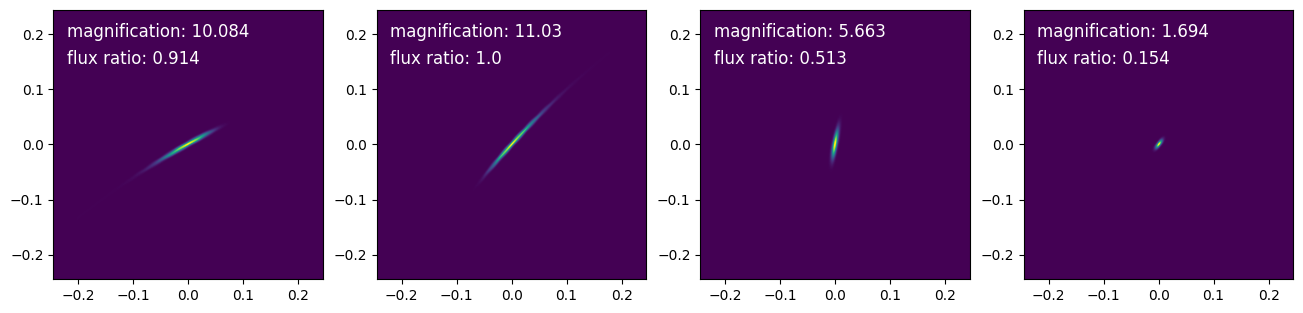

In [ ]:
forward_model(output_path, job_index, lens_data, n_keep, realization_priors, 
              macromodel_priors, tolerance=summary_statistic_tolerance,
                  verbose=True, test_mode=True, save_realizations=False)

### Examine the output

The simulation output includes files named fluxes.txt, parameters.txt, and simulation_output_1, simulation_output_2, etc.

In [ ]:
f = open(output_path + 'job_'+str(job_index)+'/parameters.txt', 'r')
param_names = f.readlines()[0]
print('PARAMETER NAMES:')
print(param_names)
f.close()

accepeted_parameters = np.loadtxt(output_path + 'job_'+str(job_index)+'/parameters.txt', skiprows=1)
print('ACCEPTED PARAMETERS:')
print(accepeted_parameters)
# the first set of parameters are the ones specified in kwargs_realization (see cell #2), the rest are the source size, 
# macromodel parameters, and the last parameter is the summary statistic

accepeted_mags = np.loadtxt(output_path + 'job_'+str(job_index)+'/fluxes.txt')
print('\nACCEPTED MAGNIFICATIONS:')
print(accepeted_mags)

### Visualize accepeted realizations

The pickeled classes in simulation_output allow you to visualize the accepeted realizations

In [ ]:
import pickle
f = open(output_path + 'job_'+str(job_index)+'/simulation_output_1', 'rb')
simulation_output = pickle.load(f)
x_image, y_image = simulation_output.data.x, simulation_output.data.y
lens_system = simulation_output.lens_system

npix = 150
rminmax = 1.25
_r = np.linspace(-rminmax, rminmax, npix)
xx, yy = np.meshgrid(_r, _r)
shape0 = xx.shape
lensmodel, kwargs_lens = lens_system.get_lensmodel()
lensmodel_macro, kwargs_macro = lens_system.get_lensmodel(include_substructure=False)

kappa = lensmodel.kappa(xx.ravel(), yy.ravel(), kwargs_lens).reshape(shape0)
kappa_macro = lensmodel_macro.kappa(xx.ravel(), yy.ravel(), kwargs_lens).reshape(shape0)

In [ ]:
import matplotlib.pyplot as plt

vminmax = 0.05
kappa_subs_nonlinear = kappa - kappa_macro
extent = [-rminmax, rminmax, -rminmax, rminmax]

fig = plt.figure(1)
fig.set_size_inches(8, 8)
plt.imshow(kappa_subs_nonlinear, vmin=-vminmax, vmax=vminmax, origin='lower', cmap='bwr', 
           extent=extent)
plt.scatter(x_image, y_image, color='k')
plt.show()

source_size_pc = accepeted_parameters[0, 4]
lens_system.plot_images(x_image, y_image, source_size_pc, lensmodel, kwargs_lens)

Using the plot_images routine in lens_system, you can also ray trace through the lens system to see what the images look like (or how they would look with an ridiculously large telescope and no PSF) 